# Transformer architecture

Материалы основаны на [The Annotated Transformer](http://nlp.seas.harvard.edu/annotated-transformer/) & [The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/)

In [ ]:
!pip install torch numpy matplotlib spacy torchtext

In [ ]:
# Standard PyTorch imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy
from torch.autograd import Variable

# For plots
%matplotlib inline
import matplotlib.pyplot as plt


## Attention mechanism

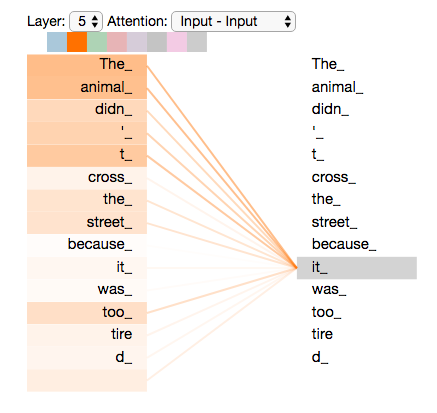

Виды attention:
1. Self-attention (+ с диагональной маской для декодера)
2. Cross-attention

Разница в том, что берем за queries, keys & values. Рассмотрим Self-attention, где queries == keys == values

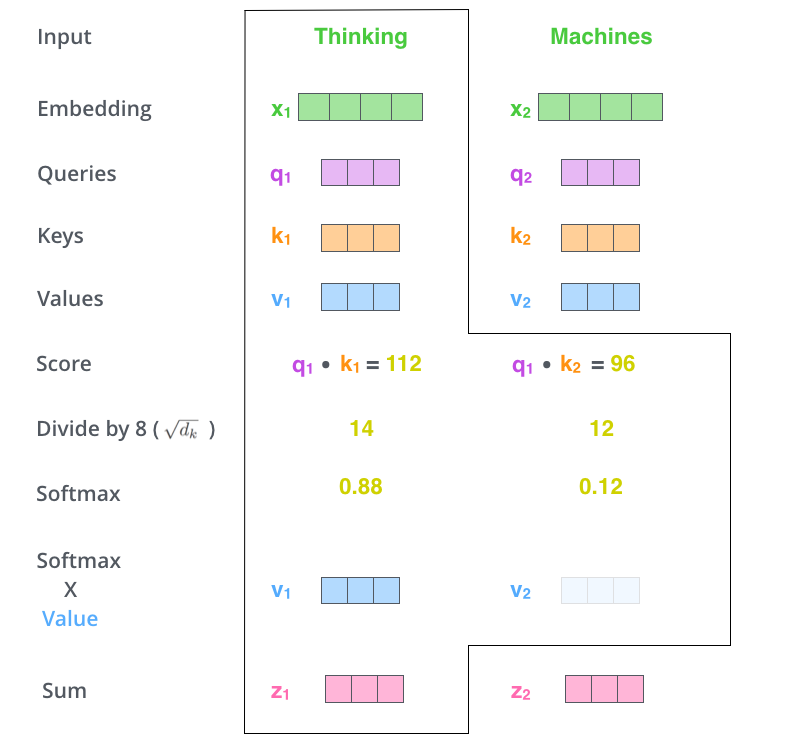

Как произвести вычисления внутри модели? С помощью матриц!

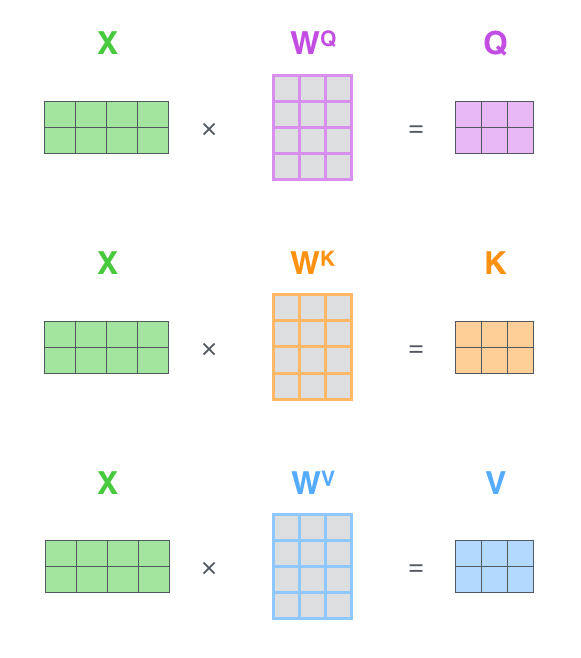

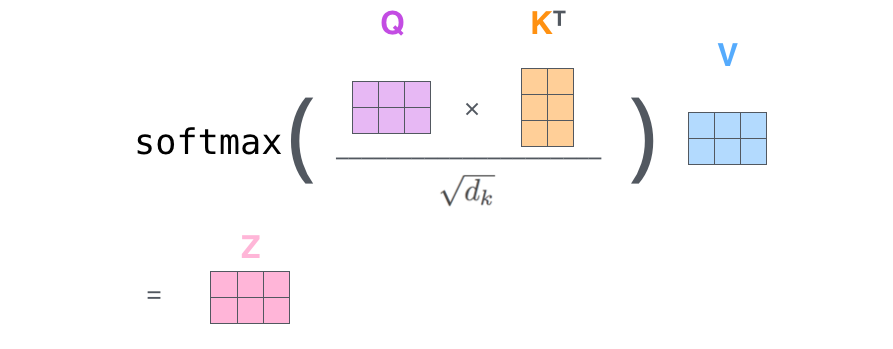

In [ ]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)

    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)

    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)

    return torch.matmul(p_attn, value), p_attn

In [ ]:
encoder_out = torch.rand(1, 3, 10)  # batch_size * sequence_size * embedding_dim
decoder_out = torch.rand(1, 5, 10)

**Задание.**

Заполните пропуски, чтобы получить Self-attention и Cross-attention.

In [ ]:
new_values, attention_scores = attention(_, _, _)  # Self-attention

In [ ]:
assert new_values.shape == encoder_out.shape
assert attention_scores.shape == torch.Size([1, encoder_out.shape[1], encoder_out.shape[1]])

In [ ]:
new_values, attention_scores = attention(_, _, _)  # Cross-attention

In [ ]:
assert new_values.shape == decoder_out.shape
assert attention_scores.shape == torch.Size([1, decoder_out.shape[1], encoder_out.shape[1]])

Для декодера нужна маска, чтобы attention не "подглядывал" в будущее

In [ ]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

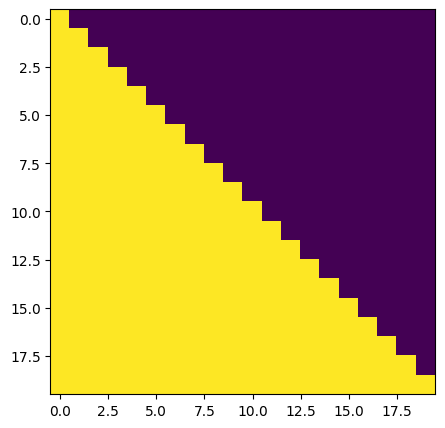

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0]);

**Задание.**

Теперь напишите attention для декодера.

In [ ]:
mask = subsequent_mask(_)

In [ ]:
new_values, attention_scores = attention(_)

In [ ]:
assert torch.all(torch.eq(attention_scores.masked_fill(mask, 0), torch.zeros((1,5,5))))

### Multi-Head Attention   

Преимущества:
1. Каждая голова может специализироваться на какой-то одной задаче
2. Не теряем в вычислении, потому что уменьшаем размерность



<center>

![](https://nlp.seas.harvard.edu/images/the-annotated-transformer_38_0.png)                                                                                                                                                            </center>                                                                                                                                                           


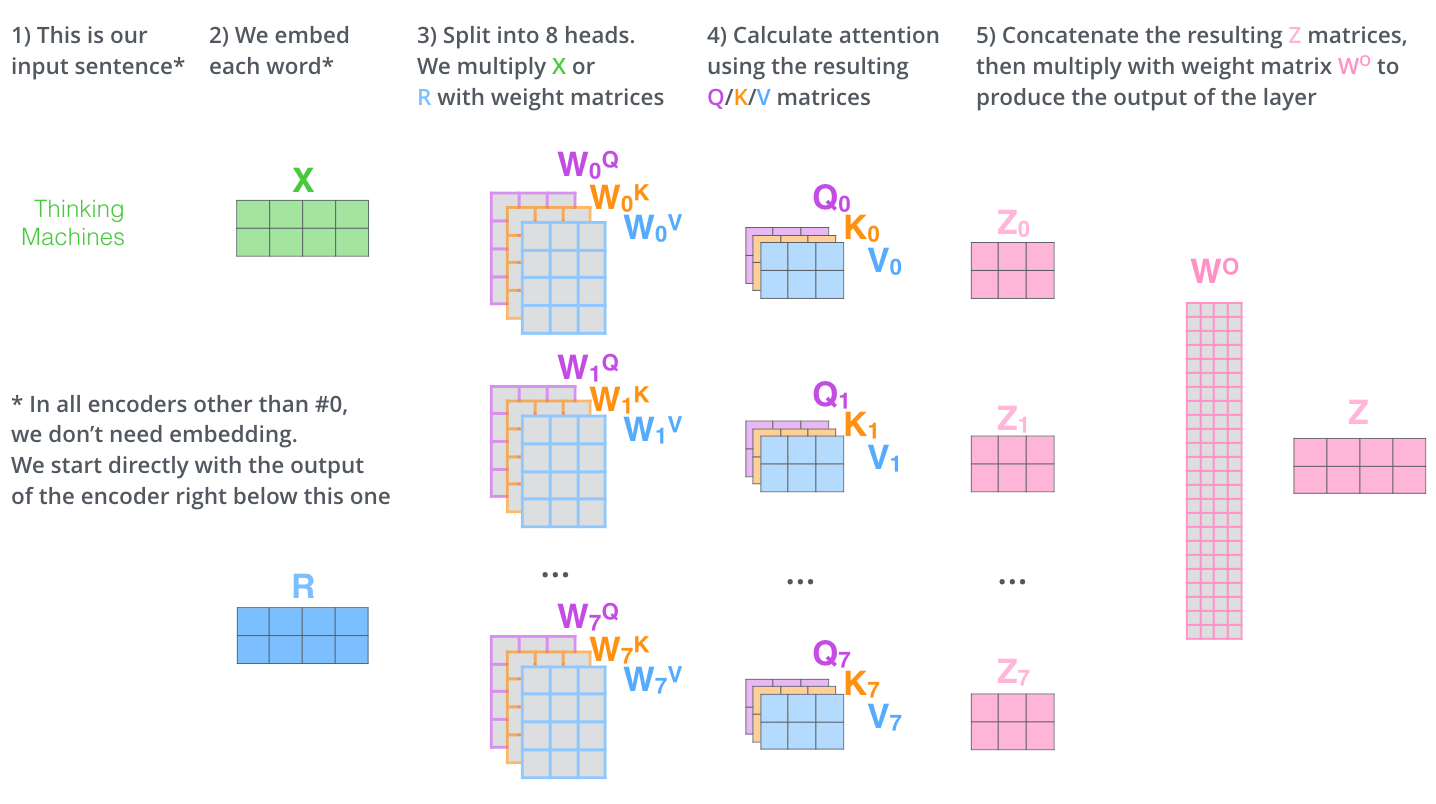

In [ ]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h  # number of heads
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(query, key, value, mask=mask,
                                 dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

**Задание**

Напишите Multi-head attention для Self-attention и Cross-attention с 2 головами

In [ ]:
mh_attention = MultiHeadedAttention(_)

In [ ]:
out = mh_attention(_)

In [ ]:
assert out.shape == encoder_out.shape

In [ ]:
out = mh_attention(_)

In [ ]:
assert out.shape == decoder_out.shape

## Model Architecture

Теперь рассмотрим архитектуру трансформера. Будем разбирать блок за блоком, начиная с верхнего уровня и переходя к более глубоким уровням.

На верхнем уровне трансформер состоит из Encoder и Decoder + Embedding слои для входной и выходной последовательностей

<center>

![](https://nlp.seas.harvard.edu/images/the-annotated-transformer_14_0.png)

</center>

### Encoder-Decoder

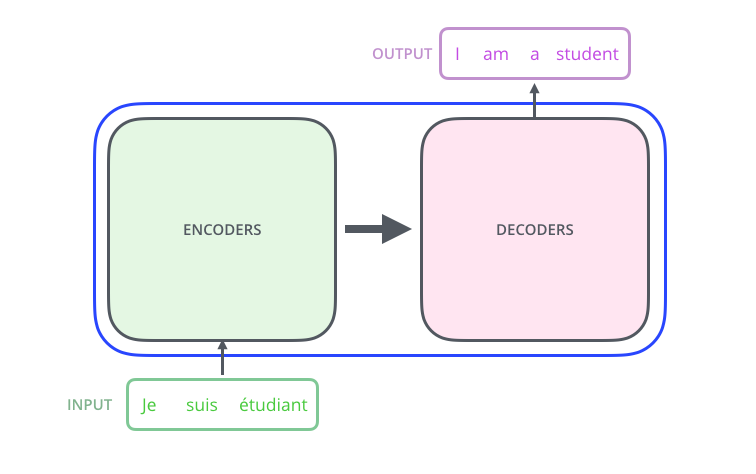

In [ ]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base model for this and many
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        memory = # your code here
        return # your code here

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

### Encoder & Decoder inside

Encoder и Decoder каждый состоит из 6 слоев, за которыми следуют Layer Norm

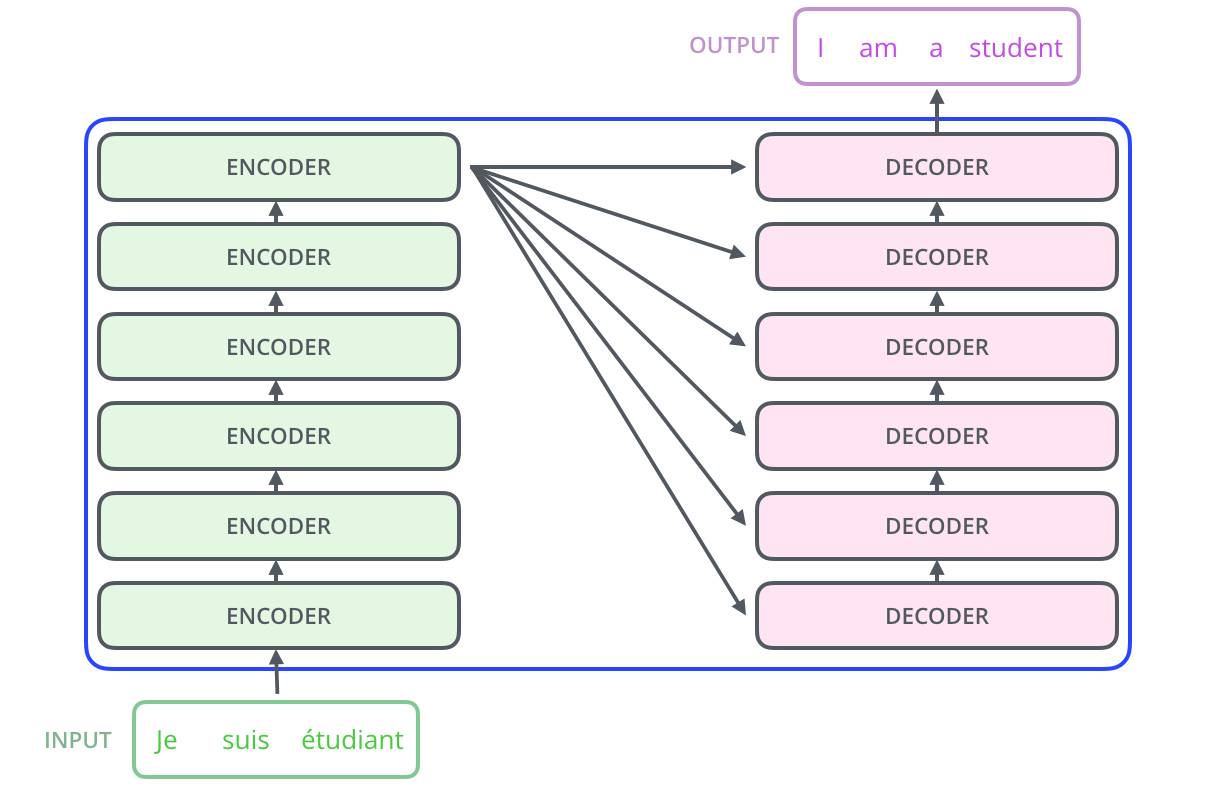

In [ ]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)

    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return x

In [ ]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return x

### Encoder & Decoder layers

Encoder состоит из двух sublayers: self-attention + feed forward

Decoder из трех: self-attention + cross-attention + feed forward

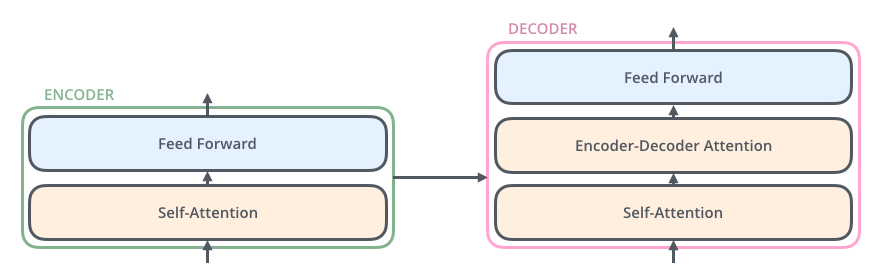

In [ ]:
class EncoderLayer(nn.Module):
    "Encoder is made up of two sublayers, self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(_, _, _, _))  # fill
        return self.sublayer[1](x, self.feed_forward)

In [ ]:
class DecoderLayer(nn.Module):
    "Decoder is made up of three sublayers, self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(_, _, _, _))  # fill
        x = self.sublayer[1](x, lambda x: self.src_attn(_, _, _, _))  # fill
        return self.sublayer[2](x, self.feed_forward)

### Different sublayers and connections between them

Разные механизмы внимания мы уже рассмотрели выше. Остается Feed Forward, Residual Commections & Layer Norm

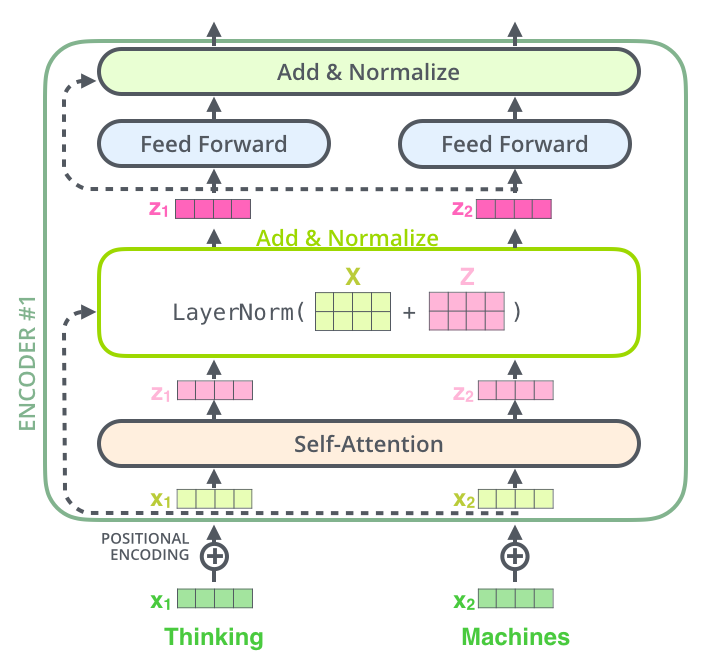

In [ ]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        # Torch linears have a `b` by default.
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [ ]:
class LayerNorm(nn.Module):
    "Construct a layernorm module"
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [ ]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity we apply the norm first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer function that maintains the same size."
        return x + self.dropout(sublayer(self.norm(x)))

### Embeddings

Как закодировать последовательности?

Эмбедим слова и их позиции

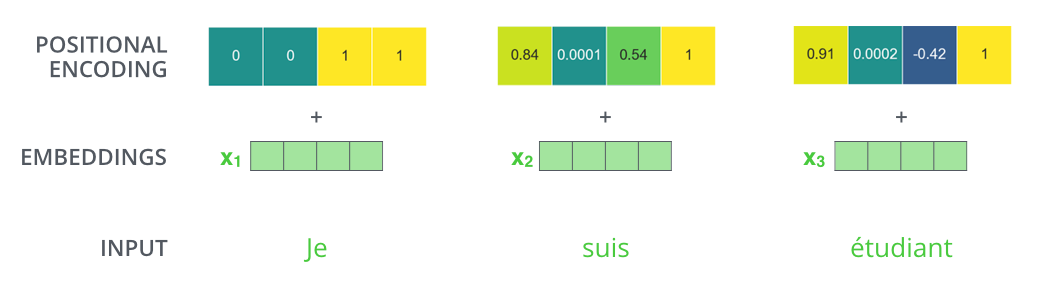

In [ ]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

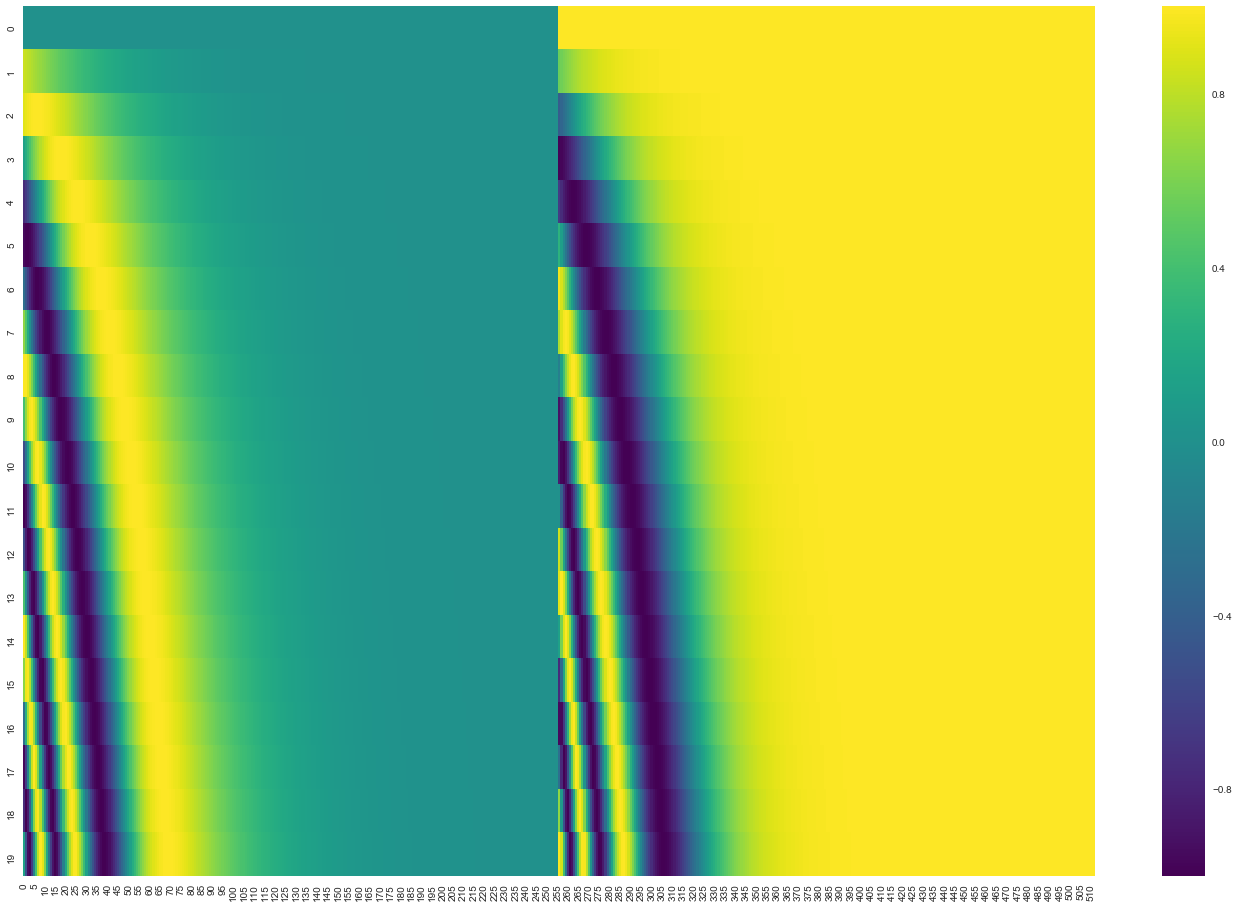

In [ ]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

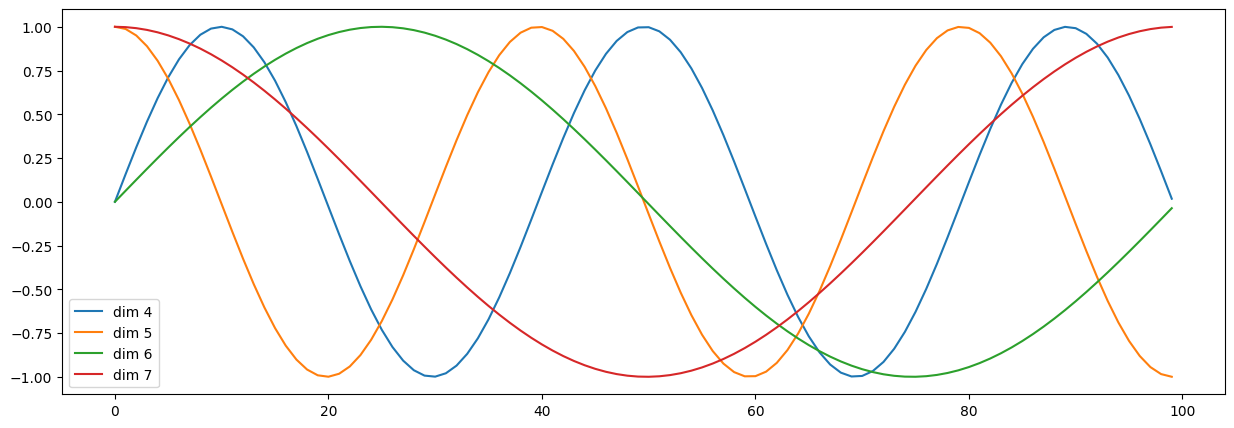

In [ ]:
# The positional encoding will add in a sine wave based on position.
# The frequency and offset of the wave is different for each dimension.
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

### Generation

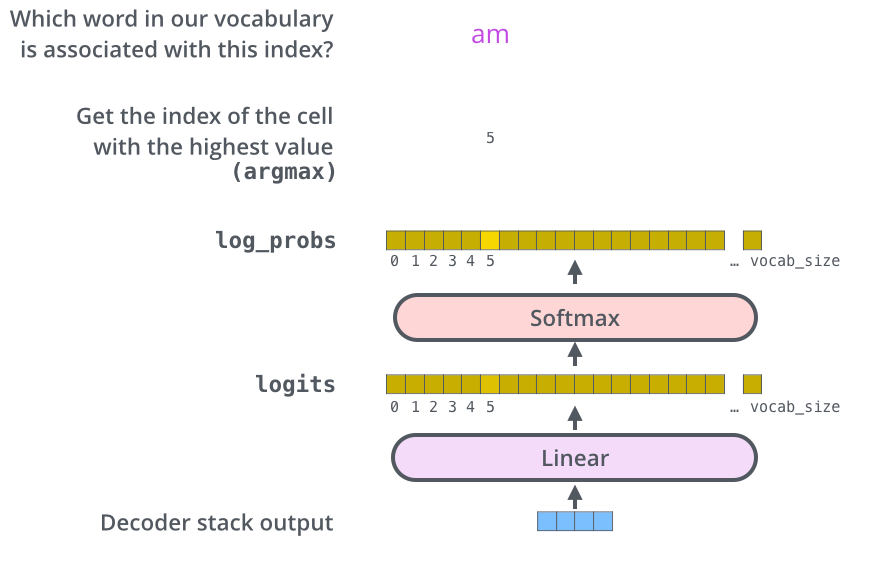

In [ ]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return # your code here

### Full Model

In [ ]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    """
    Construct a model from hyperparameters.

    params:
        src_vocab: vocabulary size of source language
        tgt_vocab: vocabulary size of target language
        N: number of layers in encoder and decoder
        d_model: model dimension
        d_ff: feed forward dimension
        h: number of heads in attention mechanism
        dropout: dropout

    """

    c = copy.deepcopy

    attn = MultiHeadedAttention(_, _)  # fill parameters for attention
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)

    encoder = Encoder(EncoderLayer(d_model, _, _, dropout), _)  # fill sublayer and number of layers
    decoder = Decoder(DecoderLayer(d_model, _, _, _, dropout), _)  # fill sublayer and number of layers

    src_embed = nn.Sequential(Embeddings(d_model, _), c(position))  # fill vocabulary size
    tgt_embed = nn.Sequential(Embeddings(d_model, _), c(position))  # fill vocabulary size

    generator = Generator(_, _)  # fill parameters for generator

    model = EncoderDecoder(
        encoder=encoder,
        decoder=decoder,
        src_embed=src_embed,
        tgt_embed=tgt_embed,
        generator=generator
    )

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    return model

In [ ]:
# Small example model.
tmp_model = make_model(src_vocab=10, tgt_vocab=10, N=2, h=8, d_model=512)
tmp_model